# Tensor Decomposition
A "hands-on" tutorial with TensorLy

- [Tensorly](http://tensorly.org/stable/index.html) is a Python library that aims at making it _easy_ to work with tensors.
- It comprises a set of tools to perform **tensor decomposition**, **tensor learning** and **tensor algebra**

In [1]:
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import face
from scipy.ndimage import zoom
from math import ceil

np.random.seed(19930316)
random_state = 12345

# Creating a Tensor

Tensors can be represented in different ways. One possibility is to see them as juxtaposed matrices.

## Example
Let us consider a tensor $X$, defined by its frontal slices, $X_{1}$ and $X_{2}$.

We have

$$X_{1} = \begin{bmatrix}
0 & 2 & 4 & 6\\
8 & 10 & 12 & 14
\\ 16 & 18 & 20 & 22
\end{bmatrix}$$

and

$$X_{2} = \begin{bmatrix}
1 & 3 & 5 & 7\\
9 & 11 & 13 & 15
\\ 17 & 19 & 21 & 23
\end{bmatrix}.$$


We can easily obtain this as a [NumPy](https://numpy.org/) array:

In [2]:
X = tl.tensor(np.arange(24).reshape((3, 4, 2)), dtype = tl.float32)

In [3]:
X

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]], dtype=float32)

It is possible to then view the frontal slices by fixing the last axis.

In [4]:
X[:, :, 0]

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]], dtype=float32)

and, of course, the back slice.

In [5]:
X[:, :, 1]

array([[ 1.,  3.,  5.,  7.],
       [ 9., 11., 13., 15.],
       [17., 19., 21., 23.]], dtype=float32)

# Different backends
In TensorLy, it is possible to set different backends.
In practice, this means that the set of tools exposed to the user is always the same, but the manner in which the various operations are computed changes.

For instance, we might be interested in using the [PyTorch](https://pytorch.org/) backend, to exploit the GPU by means of [CUDA](https://developer.nvidia.com/CUDA-zone)

In [6]:
type(X)

numpy.ndarray

In [7]:
tl.set_backend('pytorch')

In [8]:
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))
type(X)

torch.Tensor

We will set it to NumPy for the rest of the tutorial though.

In [9]:
tl.set_backend("numpy")

In [10]:
X = tl.tensor(np.arange(24).reshape((3, 4, 2)))
type(X)

numpy.ndarray

# Basic Operations
## Unfolding

Unfolding consists in rewriting the tensor as a juxtaposition of matrices.

Notice that to maintain consistency with Python's zero-based index system, **we start from 0**.

We had $X$ defined by:

$$X_{1} = \begin{bmatrix}
0 & 2 & 4 & 6\\
8 & 10 & 12 & 14
\\ 16 & 18 & 20 & 22
\end{bmatrix}$$

and

$$X_{2} = \begin{bmatrix}
1 & 3 & 5 & 7\\
9 & 11 & 13 & 15
\\ 17 & 19 & 21 & 23
\end{bmatrix}.$$

The 0-mode unfolding of it is:

$$X_{\left[0\right]} = \begin{bmatrix}
0 & 1 & 2 & 3 & 4 & 5 & 6 & 7\\
8 & 9 & 10 & 11 & 12 & 13 & 14 & 15\\
16 & 17 & 18 & 19 & 20 & 21 & 22 & 23\\
\end{bmatrix}
$$

The 1-mode unfolding is:
$$X_{\left[1\right]} = \begin{bmatrix}
0 & 1 & 8 & 9 & 16 & 17\\
2 & 3 & 10 & 11 & 18 & 19\\
4 & 5 & 12 & 13 & 20 & 21\\
6 & 7 & 14 & 15 & 22 & 23\\
\end{bmatrix}
$$

And, of course, the 2-mode unfolding is along the last axis.

$$
X_{\left[2\right]} =
\begin{bmatrix}
0 & 2 & 4 & 6 & 8 & 10 & 12 & 14 & 16 & 18 & 20 & 22\\
1 & 3 & 5 & 7 & 9 & 11 & 13 & 15 & 17 & 19 & 21 & 23
\end{bmatrix}
$$

### TensorLy
We simply do:

In [11]:
tl.unfold(X, mode = 0)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23]])

In [12]:
tl.unfold(X, mode = 1)

array([[ 0,  1,  8,  9, 16, 17],
       [ 2,  3, 10, 11, 18, 19],
       [ 4,  5, 12, 13, 20, 21],
       [ 6,  7, 14, 15, 22, 23]])

In [13]:
tl.unfold(X, mode = 2)

array([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22],
       [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]])

# Outer Product

We now compute the outer product between two arrays:

$$ x = \begin{bmatrix}
2 \\
5 \\
\end{bmatrix}
$$

and 

$$y = \begin{bmatrix}
9\\
10\\
\end{bmatrix}.
$$

In [14]:
x = tl.tensor(np.array([2, 5]))
x

array([2, 5])

In [15]:
y = tl.tensor(np.array([9, 10]))
y

array([ 9, 10])

We obtain

$$ X = x \otimes y = xy^{t} = \begin{bmatrix}18 & 20\\ 45 & 50 \end{bmatrix}.$$

In [16]:
X = tl.tenalg.tensor_dot(x, y)

In [17]:
X

array([[18, 20],
       [45, 50]])

# CP Decomposition

- To give an example of CP decomposition, we are going to consider a simple case. Imagine that we are capturing spatio-temporal data for 90 samples.
- We are going to employ a tensor to give a natural representation of these data.
- We assume there to be only three distinct "archetypes" of data: Case 01, Case 02, and Case 03.
- We set the spatial values to simply be Gaussian. As for the temporal values, we have piecewise constant values, with possible jumps when $t = 50$.
- We are then going to stack these values. Notice that we will do so in order (the algorithm won't know this, though...).
- We want to see what happens if we apply CP decomposition.

## Data Construction

In [18]:
num_points = 100
space_index = np.linspace(start = -1, stop = 1, num = num_points)
bell_curve = norm.pdf(space_index, loc = 0, scale = 0.5).reshape((1, num_points))

### Case 01

In [19]:
case_01 = np.repeat(bell_curve, repeats=num_points, axis = 0).T

Text(0.5, 1.0, 'Case 01')

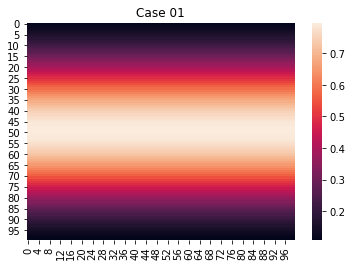

In [20]:
sns.heatmap(case_01, annot=False).set_title("Case 01")

### Case 02

In [21]:
case_02 = np.repeat(bell_curve, repeats=num_points, axis = 0).T
case_02[:, 51:100] = case_02[:, 51:100] + 0.1

Text(0.5, 1.0, 'Case 02')

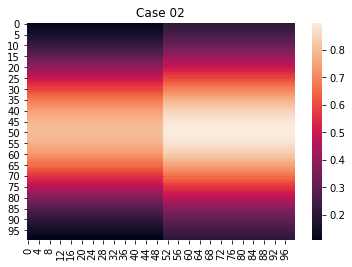

In [22]:
sns.heatmap(case_02, annot=False).set_title("Case 02")

### Case 03

In [23]:
case_03 = np.repeat(bell_curve, repeats=num_points, axis = 0).T
case_03[:, 51:100] = case_02[:, 51:100] - 0.1

Text(0.5, 1.0, 'Case 03')

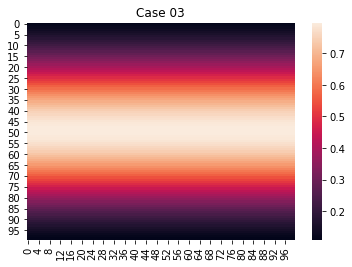

In [24]:
sns.heatmap(case_03, annot=False).set_title("Case 03")

In [25]:
X = np.empty(shape = (90, 100, 100))
for i in range(30):
    X[i, :, :] = case_01 + np.random.normal(10000, 0.1, (100, 100))
    X[i + 30, :, :] = case_02 + np.random.normal(10000, 0.1, (100, 100))
    X[i + 60, :, :] = case_03 + np.random.normal(10000, 0.1, (100, 100))

### Samples
We now show the values for three different samples.

Text(0.5, 1.0, 'Sample 26')

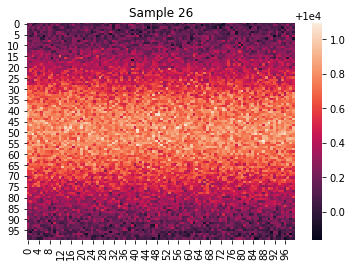

In [26]:
sns.heatmap(X[26, :, :], annot=False).set_title("Sample 26")

Text(0.5, 1.0, 'Sample 39')

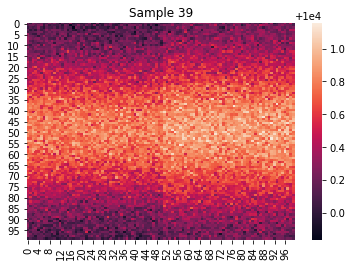

In [27]:
sns.heatmap(X[39, :, :], annot=False).set_title("Sample 39")

Text(0.5, 1.0, 'Sample 66')

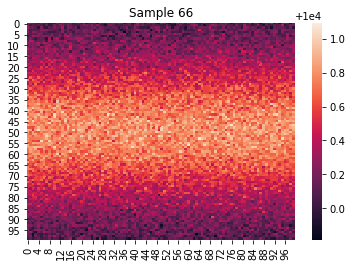

In [28]:
sns.heatmap(X[66, :, :], annot=False).set_title("Sample 66")

In [29]:
X = tl.tensor(X)

## CP Decomposition
We now perform the decomposition.

In [30]:
weights, factors = parafac(X, rank = 1)

## Analysis of the results

<AxesSubplot:xlabel='sample_index', ylabel='sample'>

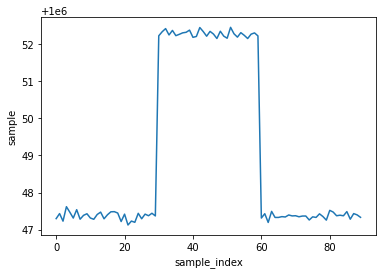

In [31]:
sample_component = pd.DataFrame({'sample_index' : [i for i in np.arange(90)], 'sample' : factors[0].reshape((factors[0].shape[0],))})
sns.lineplot(data = sample_component, x = 'sample_index', y = 'sample')

<AxesSubplot:xlabel='space_index', ylabel='space'>

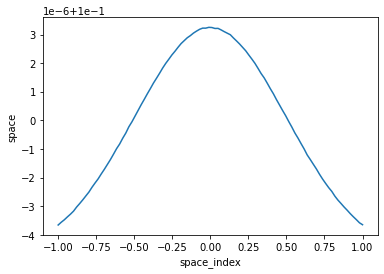

In [32]:
space_component = pd.DataFrame({'space_index': space_index, 'space' : factors[1].reshape((factors[1].shape[0],))})
sns.lineplot(data = space_component, x = 'space_index', y = 'space')

<AxesSubplot:xlabel='time_index', ylabel='time'>

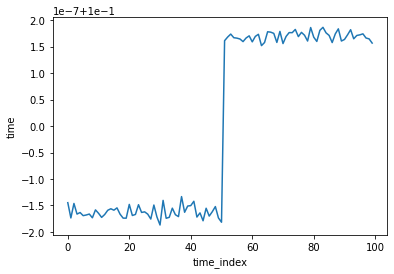

In [33]:
time_component = pd.DataFrame({'time_index': [i for i in range(num_points)], 'time': factors[2].reshape((factors[2].shape[0],))})
sns.lineplot(data = time_component, x = 'time_index', y = 'time')

# A Quick Tucker vs CP comparison

We are now going to compress an image using the two different approaches.
An image is represented by a tensor: we have the number of pixels on the x and y axis, plus three colour levels (red, green and blue).

For the experiment, we are going to use the photograph of a raccoon (who kindly agreed).

Here we see the raccoon in their best tensor pose:

In [34]:
face()

array([[[121, 112, 131],
        [138, 129, 148],
        [153, 144, 165],
        ...,
        [119, 126,  74],
        [131, 136,  82],
        [139, 144,  90]],

       [[ 89,  82, 100],
        [110, 103, 121],
        [130, 122, 143],
        ...,
        [118, 125,  71],
        [134, 141,  87],
        [146, 153,  99]],

       [[ 73,  66,  84],
        [ 94,  87, 105],
        [115, 108, 126],
        ...,
        [117, 126,  71],
        [133, 142,  87],
        [144, 153,  98]],

       ...,

       [[ 87, 106,  76],
        [ 94, 110,  81],
        [107, 124,  92],
        ...,
        [120, 158,  97],
        [119, 157,  96],
        [119, 158,  95]],

       [[ 85, 101,  72],
        [ 95, 111,  82],
        [112, 127,  96],
        ...,
        [121, 157,  96],
        [120, 156,  94],
        [120, 156,  94]],

       [[ 85, 101,  74],
        [ 97, 113,  84],
        [111, 126,  97],
        ...,
        [120, 156,  95],
        [119, 155,  93],
        [118, 154,  92]]

And here we see them as they would appear in nature:

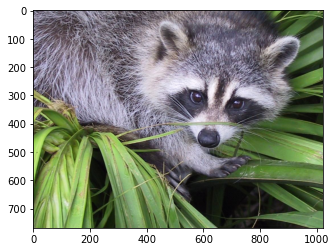

In [35]:
plt.gray()
plt.imshow(face())
plt.show()

We are now ready to apply the decompositions to the tensor, to get a compressed image.

In [36]:
image = face()
image = tl.tensor(zoom(face(), (0.3, 0.3, 1)), dtype='float64')

In [37]:
def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

In [38]:
# Rank of the CP decomposition
cp_rank = 25
# Rank of the Tucker decomposition
tucker_rank = [100, 100, 2]

In [39]:
# Perform the CP decomposition
weights, factors = parafac(image, rank=cp_rank, init='random', tol=10e-6)
# Reconstruct the image from the factors
cp_reconstruction = tl.cp_to_tensor((weights, factors))

In [40]:
# Tucker decomposition
core, tucker_factors = tucker(image, rank=tucker_rank, init='random', tol=10e-5, random_state=random_state)
tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))

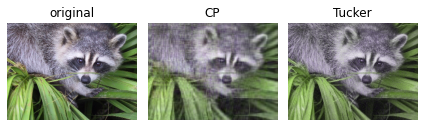

In [41]:
# Plotting the original and reconstruction from the decompositions
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')
ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
ax.imshow(to_image(cp_reconstruction))
ax.set_title('CP')
ax = fig.add_subplot(1, 3, 3)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))
ax.set_title('Tucker')
plt.tight_layout()
plt.show()

# References

1. [TensorLy](http://tensorly.org/stable/index.html)
1. [NumPy](https://numpy.org/)
1. [SciPy](https://www.scipy.org/)
1. [PyTorch](https://pytorch.org/)
1. [Seaborn](https://seaborn.pydata.org/index.html)
1. https://www.alexejgossmann.com/tensor_decomposition_CP/